In [1]:
'''

This code is part of the SIPN2 project focused on improving sub-seasonal to seasonal predictions of Arctic Sea Ice. 
If you use this code for a publication or presentation, please cite the reference in the README.md on the
main page (https://github.com/NicWayand/ESIO). 

Questions or comments should be addressed to nicway@uw.edu

Copyright (c) 2018 Nic Wayand

GNU General Public License v3.0


'''

'''
Plot forecast maps with all available models.
'''

%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
import matplotlib.pyplot as plt
from collections import OrderedDict
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

from esio import EsioData as ed
from esio import ice_plot
from esio import import_data
from esio import metrics
import dask
import xskillscore as xs

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=.8, rc={"lines.linewidth": 2.5})

In [2]:
# from dask.distributed import Client
# client = Client(n_workers=2)
# client = Client()
# client
dask.config.set(scheduler='threads')  # overwrite default with threaded scheduler
# dask.config.set(scheduler='processes')  # overwrite default with threaded scheduler

In [3]:
# Parameters
pred_year = 2018 # Prediction year
Y_Start = 1979
Y_End = 2017

In [4]:
#############################################################
# Load in Data
#############################################################

E = ed.EsioData.load()
mod_dir = E.model_dir


In [5]:
# Get most recent obs
ds_81 = xr.open_mfdataset(E.obs['NSIDC_0081']['sipn_nc']+'_yearly/*.nc', concat_dim='time', autoclose=True, parallel=True)
doyall = metrics.get_DOY(ds_81.time)
ds_81.coords['doy'] = xr.DataArray(doyall, dims='time', coords={'time':ds_81.time})

# Get mean sic by DOY
print("Need up update to 1979-2017 mean")
mean_1980_2010_sic = xr.open_dataset(os.path.join(E.obs_dir, 'NSIDC_0051', 'agg_nc', 'mean_1980_2010_sic.nc')).sic

end_date = datetime.datetime.now()
end_date = datetime.datetime(end_date.year, end_date.month, end_date.day) # Set hour min sec to 0. 
start_date = datetime.datetime(end_date.year, 1, 1) # Set hour min sec to 0. 

Need up update to 1979-2017 mean


# Load in Clim base line models

In [13]:
# Climatology model trend
all_files = os.path.join(mod_dir,'climatology',runType,'sipn_nc', str(end_date.year)+'*.nc')
files = glob.glob(all_files)
obs_clim_model = xr.open_mfdataset(sorted(files), 
        chunks={'time': 30, 'x': 304, 'y': 448},  
         concat_dim='time', autoclose=True, parallel=True)
obs_clim_model = obs_clim_model['sic']
obs_clim_model = obs_clim_model.swap_dims({'time':'doy'})
obs_clim_model

<xarray.DataArray 'sic' (doy: 366, y: 448, x: 304)>
dask.array<shape=(366, 448, 304), dtype=float64, chunksize=(1, 448, 304)>
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 295 296 297 298 299 300 301 302 303
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 439 440 441 442 443 444 445 446 447
    lat      (x, y) float64 31.1 31.25 31.4 31.55 ... 34.92 34.77 34.62 34.47
    lon      (x, y) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
    xm       (x) int64 -3850000 -3825000 -3800000 ... 3675000 3700000 3725000
    ym       (y) int64 5850000 5825000 5800000 ... -5275000 -5300000 -5325000
  * doy      (doy) int64 1 2 3 4 5 6 7 8 9 ... 359 360 361 362 363 364 365 366
    time     (doy) datetime64[ns] 2018-01-01 2018-01-02 ... 2019-01-01

In [9]:
cmod = 'dampedAnomalyTrend'
runType = 'forecast'
all_files = os.path.join(mod_dir,cmod,runType,'sipn_nc', str(end_date.year)+'*.nc')
files = glob.glob(all_files)

dampedAnomalyTrend = xr.open_mfdataset(sorted(files), 
        chunks={'nj': 304, 'ni': 448},  
         concat_dim='init_time', autoclose=True, parallel=True)
dampedAnomalyTrend

<xarray.Dataset>
Dimensions:    (ensemble: 1, fore_time: 60, init_time: 318, ni: 448, nj: 304)
Coordinates:
  * nj         (nj) int64 0 1 2 3 4 5 6 7 8 ... 296 297 298 299 300 301 302 303
  * ni         (ni) int64 0 1 2 3 4 5 6 7 8 ... 440 441 442 443 444 445 446 447
    lat        (nj, ni) float64 31.1 31.25 31.4 31.55 ... 34.77 34.62 34.47
    lon        (nj, ni) float64 168.3 168.4 168.5 168.7 ... -9.745 -9.872 -9.999
  * fore_time  (fore_time) timedelta64[ns] 0 days 7 days ... 406 days 413 days
  * init_time  (init_time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-11-14
Dimensions without coordinates: ensemble
Data variables:
    sic        (init_time, ensemble, fore_time, ni, nj) float64 dask.array<shape=(318, 1, 60, 448, 304), chunksize=(1, 1, 60, 448, 304)>

In [11]:
## Aggregate

In [16]:
obs_clim_model_agg = obs_clim_model.sum(dim=['x','y'])
obs_clim_model_agg

<xarray.DataArray 'sic' (doy: 366)>
dask.array<shape=(366,), dtype=float64, chunksize=(1,)>
Coordinates:
  * doy      (doy) int64 1 2 3 4 5 6 7 8 9 ... 359 360 361 362 363 364 365 366
    time     (doy) datetime64[ns] 2018-01-01 2018-01-02 ... 2019-01-01

In [12]:
dampedAnomalyTrend_agg = dampedAnomalyTrend.sic.sum(dim=['nj','ni']).isel(ensemble=0)
dampedAnomalyTrend_agg = import_data.get_valid_time(dampedAnomalyTrend_agg)
dampedAnomalyTrend_agg

<xarray.DataArray 'sic' (init_time: 318, fore_time: 60)>
dask.array<shape=(318, 60), dtype=float64, chunksize=(1, 60)>
Coordinates:
  * fore_time   (fore_time) timedelta64[ns] 0 days 7 days ... 406 days 413 days
  * init_time   (init_time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-11-14
    valid_time  (init_time, fore_time) datetime64[ns] 2018-01-01 ... 2020-01-01

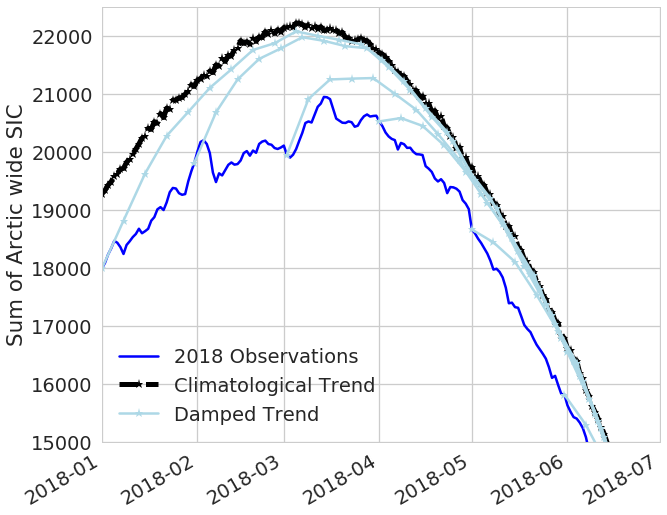

In [44]:
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})
f = plt.figure(figsize=(10,8))


# # Get 2018 obs
target_year_obs = ds_81.sic.sel(time=slice('2018-01-01',end_date)).sum(dim=['x','y'])

# Plot target year obs
target_year_obs.plot(color='b', label='2018 Observations')

# Plot climatological trend
obs_clim_model_agg.plot(color='k',linestyle='--', label='Climatological Trend', marker='*', linewidth=5)

# Plot climatological mean
# mean_1980_2010_sic_agg.swap_dims({'time':'valid_time'}).plot(color='m', label='1980-2010 mean', linewidth=5)


addleg = True
for it in dampedAnomalyTrend_agg.init_time.values[0::30]:

    Y = dampedAnomalyTrend_agg.sel(init_time=it)
    plt.plot(Y.valid_time, Y.values, color='lightblue', marker='*', label='Damped Trend')
    
    if addleg:
        plt.legend()
        addleg = False

plt.ylim([15000,22500])
plt.xlim([np.datetime64('2018-01-01'),np.datetime64('2018-07-01')])

plt.ylabel('Sum of Arctic wide SIC')
plt.xlabel('')

f_out = os.path.join('/home/disk/sipn/nicway/Nic/figures/pres/A','comparison_models.png')
f.savefig(f_out,bbox_inches='tight', dpi=300)